# Multiagents

- Agent = LLM+Tool and if there are multiple agents and interacting within themselves ato achive a task is called Multiagent Application. These agents interacts within themselves in two ways. 
    
- Supervisor (Manager–Worker) Architecture:
    - This architecture has one main agent (the supervisor) that controls or manages several specialized worker agents. 
    - The supervisor decides who should do what, sends tasks to workers, collects their results, and combines everything into a final answer. 
    - It is useful when tasks can be split—for example: planning → researching → writing → reviewing.
    - Example
        - A “Project Manager” AI assigns tasks to a “Research Agent,” “Coding Agent,” and “Editor Agent.” Each worker does its part, and the manager assembles the final outputs.
    - Supervison architecture can be extended to hierarchial architecture

- Network Agent (Decentralized / Peer-to-Peer) Architecture or Collaborative Agent
    - In this architecture, all agents act like peers in a network.
    - There is no central supervisor—agents communicate directly, exchange information, and collaborate to solve problems.
    - Each agent has its own skills and goals, and they coordinate by sending messages to each other
    - Example
        - A “Math Agent,” “Science Agent,” and “Language Agent” communicate together.
        - If a question involves both math and science, they share partial answers until they reach a final solution.

- https://github.com/langchain-ai/langgraph/tree/main/docs/docs/tutorials/multi_agent
- Each node uses Command to give instruction/information to other nodes 




## Hierarchical Agents:
- This notebook is inspired by the paper AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation, by Wu, et. al. In the rest of this notebook, you will:
    - Define the agents' tools to access the web and write files
    - Define some utilities to help create the graph and agents
    - Create and define each team (web research + doc writing)
    - Compose everything together.


---user --> Supervisor --> Research team (Search and Websscrapper) or Document authority team (Writer, Note Taker, ChartGenerator)

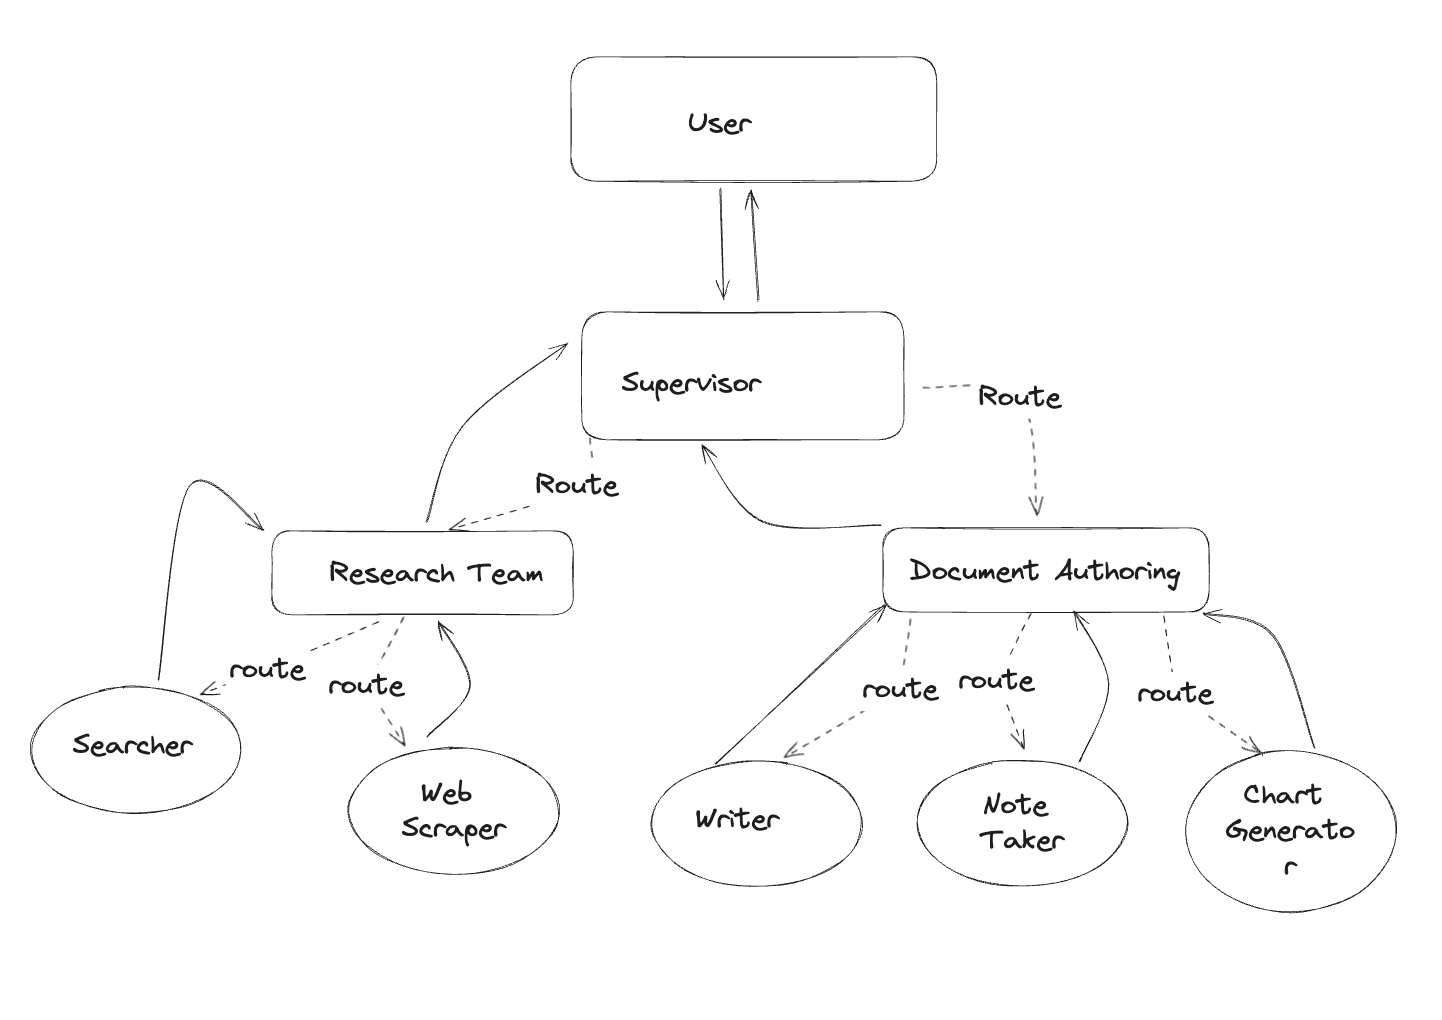

### Setup

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_PROJECT"]="AgentiAICourse_01"
os.environ["LANGCHAIN_TRACING_V2"]="true"

### Research Team

#### Web Searcch and Scrapping Agents

In [ ]:
from typing import Annotated, List
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command

TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
from langchain_tavily import TavilySearch
tavily_tool=TavilySearch(tavily_api_key=TAVILY_API_KEY)
#search_tool.invoke("what is GDP of US in 2024", max_results=5)


# Search Agent
llm = ChatOpenAI(model="gpt-4o")
search_agent = create_react_agent(llm, tools=[tavily_tool])


# Websrape agent
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])

#### Helper Utilities: Supervisor and Workers
- We are going to create a few utility functions to make it more concise when we want to:
    - Create a worker agent.
    - Create a supervisor for the sub-graph.

In [20]:

from langchain_core.messages import HumanMessage, trim_messages

class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

#### Search Node, Web Scrapper Node and Supervisor Node for seach and Webscrapper

In [ ]:

def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

#### Research Team Graph

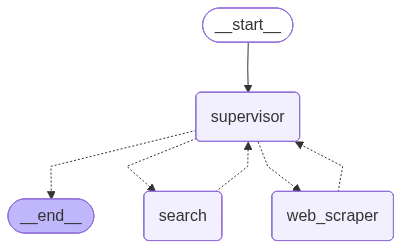

In [ ]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")a
research_graph = research_builder.compile()
from IPython.display import Image, display
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [15]:
for s in research_graph.stream(
    {"messages": [("user", "What is the recent update about H1B?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content="The recent updates on the H-1B visa include:\n\n1. **Enhanced Social Media Scrutiny**: The U.S. has announced that H-1B visa applicants will now have their social media profiles scrutinized as part of the vetting process. This policy aims to verify the admissibility of visa applicants, especially those who might pose a threat to U.S. national security or public safety. The review will include scrutinizing the applicants' online presence and digital activities.\n\n2. **Fee Hike and Vetting**: In recent developments under the Trump administration, the application fee for most H-1B visa petitions has been raised to $100,000. Additionally, there is an increase in vetting specifically targeting H-1B applicants, particularly concerning censorship of free speech, which is an area often involving technology and social media sectors.\n\n3. **Policy Shift in Screening**: There has been a significant shift in th

### Document Authority Team

#### Creating Agents for notes taking, writing and chat generating

In [25]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = "./data/hierarchialagent"


@tool
def create_outline(points: Annotated[List[str], "List of main points or sections."],file_name: Annotated[str, "File path to save the outline."],) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
    ) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
    ) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
        ) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)

doc_writer_agent = create_react_agent(llm,tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)

chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)




#### Creating nodes for Notes taking, Wrting and Chats using agents

In [26]:
def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )



def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(llm, ["doc_writer", "note_taker", "chart_generator"])

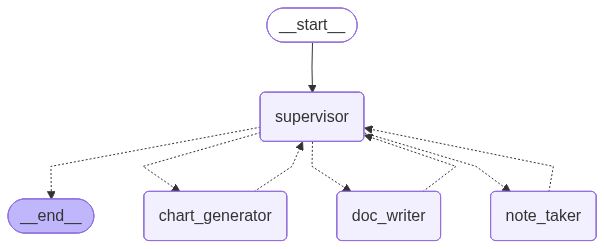

In [27]:
#### Create graph for Document authority
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [29]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about love and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content="It appears there is a persistent error with saving the document or performing related operations. Unfortunately, I'm unable to complete the task as requested due to these technical difficulties. You may want to try saving the poem outline and poem text yourself using a text editor or other document processing tool. \n\nIf you need further assistance or another type of task, feel free to ask!", additional_kwargs={}, response_metadata={}, name='note_taker', id='21edaeb1-b839-4347-b69e-35fdced1ac21')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content="It seems there was a technical issue when trying to save the poem to a file. You may want to try saving the text using a text editor or another document processing tool. Here is the poem text you can copy:\n\n---\n\n**Title: Eternal Embrace**\n\nIn the quiet whisper of a moonlit night,  \nLies the mys

### Supervisor for Research Team and Document Authority Team


#### Defining nodes for Research and Document authority

In [32]:
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )

#### Graph for Research Team adn Writing Team

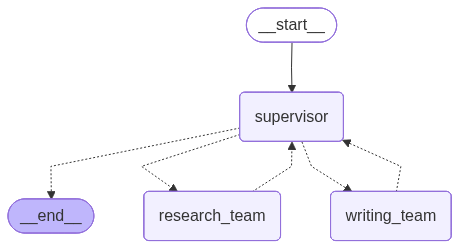

In [34]:
# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

from IPython.display import Image, display
display(Image(super_graph.get_graph().draw_mermaid_png()))


In [35]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='### Report on AI Agents\n\nAI agents are cutting-edge, autonomous systems engineered to execute a variety of tasks independently. Unlike traditional software, these agents possess the ability to function autonomously, making decisions and carrying out actions with minimal human oversight. Their design principles ensure they are goal-oriented and proactive, capable of sensing their digital or physical environments and continuously learning from their interactions to enhance their functionality over time.\n\n#### Key Characteristics of AI Agents:\n1. **Autonomy:** A defining feature of AI agents is their capacity to operate independently, which reduces the need for constant human input. This allows them to manage tasks efficiently and adapt to any dynamic changes in their environment.\n\n2. **Goal-Oriented:** AI agents are structured to meet specific goals, employing their decision-making 